#Classificação de músicas do Spotify
##Classificação de músicas do Spotify
Este notebook utiliza um conjunto de dados contendo faixas do Spotify classificadas em 125 gêneros diferentes. Cada faixa apresenta diversas características de áudio que podem ser exploradas em diferentes tipos de análises.

## Possíveis usos da base de dados:
- Construção de sistemas de recomendação com base em preferências do usuário;
- Modelos de classificação baseados em atributos de áudio e gêneros;
- Outras aplicações criativas que envolvam análise de músicas.

## Objetivo do Projeto

Nosso objetivo é construir um modelo preditivo capaz de classificar músicas entre agitadas e lentas, com base em suas características de áudio.

Utilizaremos a base de dados **"Spotify Tracks Dataset"**, disponível no Kaggle:  
🔗 [Acessar o dataset](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from re import X
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_columns', None)
df = pd.read_csv('/content/dataset.csv')

In [4]:
df.head()

print(df.head())

print("\nInformações do dataset:")
print(df.info())

print("\nEstatísticas descritivas:")
print(df.describe())
df.shape

   Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   


(114000, 21)

## Criando a Variável Alvo (Target)

A coluna `valence` representa, em uma escala de 0.0 a 1.0, o nível de positividade emocional de uma música.  
- **Alta valência**: músicas com clima positivo (felizes, alegres, eufóricas);  
- **Baixa valência**: músicas mais negativas (tristes, melancólicas, irritadas).

Vamos utilizar essa coluna como critério para criar a variável alvo do nosso modelo, definindo se uma música é **agitada** ou **lenta**.

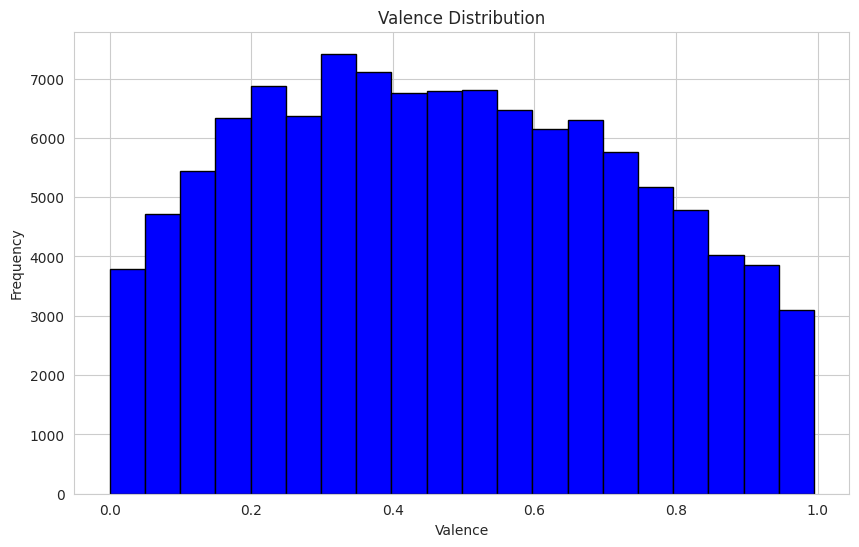

In [5]:
plt.hist(df['valence'], bins=20, color='blue', edgecolor='black')
plt.title('Valence Distribution')
plt.xlabel('Valence')
plt.ylabel('Frequency')
plt.show()

In [6]:
df['valence'].describe()

,valence
count,114000.000000
mean,0.474068
std,0.259261
min,0.000000
25%,0.260000
50%,0.464000
75%,0.683000
max,0.995000


In [7]:
def categorizar_valence(row):
  if row['valence'] > 0.5:
    return 'Agitada'
  else:
    return 'Lenta'

df['target'] = df.apply(categorizar_valence, axis=1)
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,target
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,Agitada
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,Lenta
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,Lenta
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,Lenta
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,Lenta


#Feature Engineering
Como próximo passo, vamos armazenar em um novo dataframe apenas as colunas necessárias para nossa classificação de músicas.



In [8]:
df_musica = df.drop(['Unnamed: 0', 'track_id'], axis=1)
df_musica.head()

,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,target
0,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,Agitada
1,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,Lenta
2,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,Lenta
3,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,Lenta
4,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,Lenta


#Tratando os dados categóricos
LabelEncoder: Essa classe é utilizada para codificar rótulos de classes em números inteiros. É frequentemente usado quando se trabalha com algoritmos de aprendizado supervisionado que requerem rótulos numéricos.

In [9]:
def label_encoder_dataframe(df, columns_to_encode):
  from sklearn.preprocessing import LabelEncoder

  le = LabelEncoder()
  for column in columns_to_encode:
    if column in df.columns:
      df[column] = le.fit_transform(df[column])
    else:
      print(f"A lista possui colunas que não existem no Dataframe")
  return df

colunas_a_codificar = ['artists', 'album_name', 'track_name', 'explicit', 'track_genre', 'target']
df_musica = label_encoder_dataframe(df_musica, colunas_a_codificar)
df_musica.head()

,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,target
0,10357,8100,11741,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,0,0
1,3287,14796,22528,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,0,1
2,12397,39162,60774,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,0,1
3,14839,8580,9580,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,0,1
4,5255,16899,25689,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,0,1


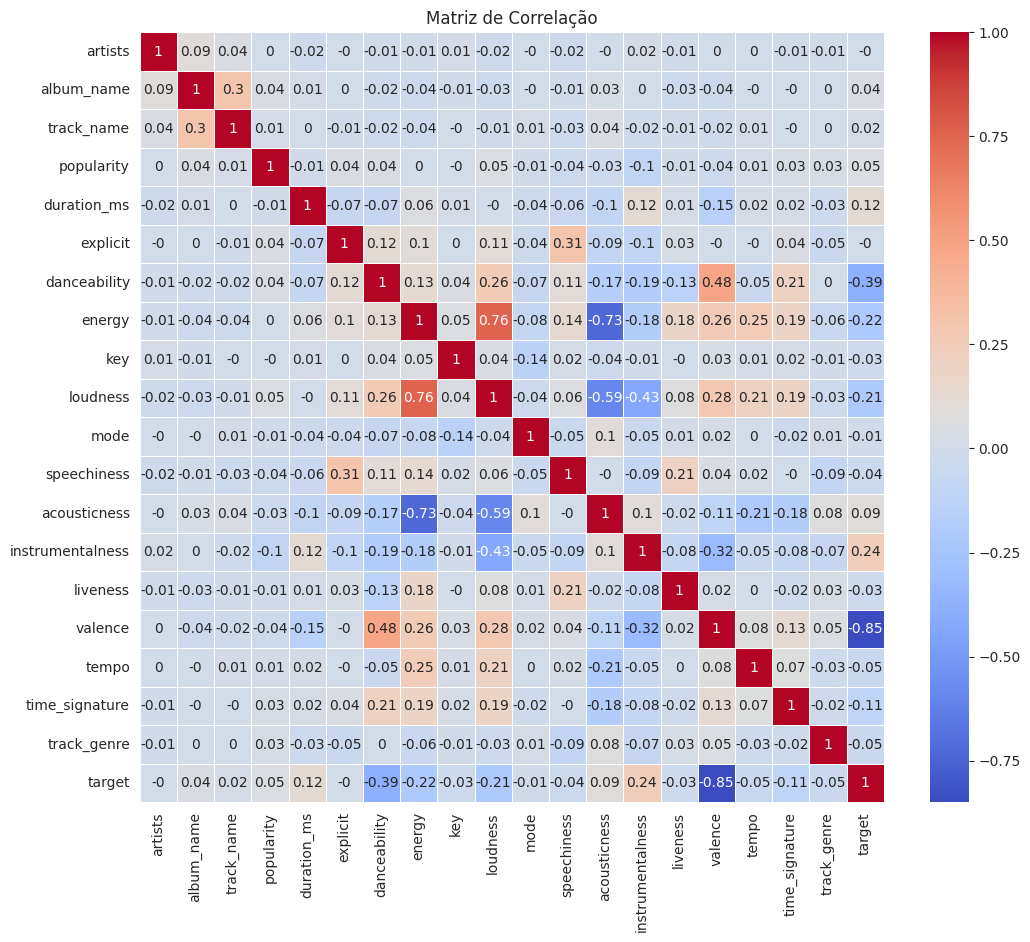

In [10]:
correlation_matrix = df_musica.corr().round(2)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

## Verificando o Balanceamento da Variável Alvo

Antes de treinar os modelos, é importante verificar se a variável alvo está balanceada — ou seja, se há uma distribuição semelhante entre as classes de músicas agitadas e lentas. Desequilíbrios podem afetar a performance do modelo, especialmente em classificadores binários.


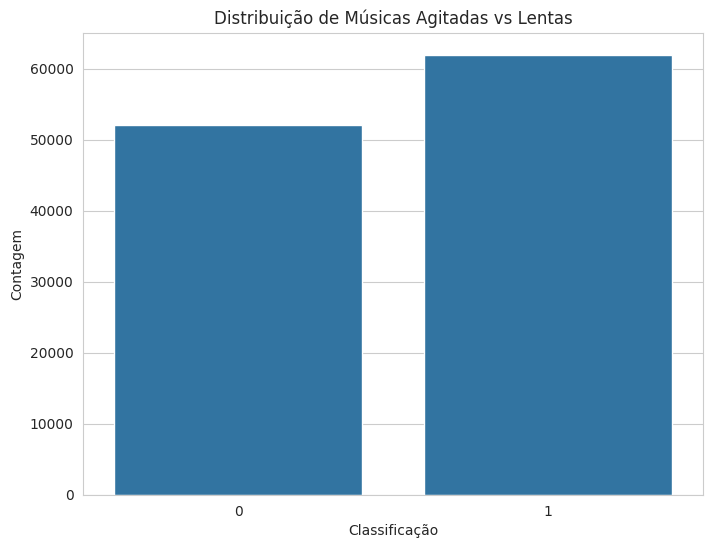

,count,mean,std,min,25%,50%,75%,max
danceability,114000.0,0.566800,0.173542,0.000,0.45600,0.580000,0.6950,0.985
energy,114000.0,0.641383,0.251529,0.000,0.47200,0.685000,0.8540,1.000
loudness,114000.0,-8.258960,5.029337,-49.531,-10.01300,-7.004000,-5.0030,4.532
speechiness,114000.0,0.084652,0.105732,0.000,0.03590,0.048900,0.0845,0.965
acousticness,114000.0,0.314910,0.332523,0.000,0.01690,0.169000,0.5980,0.996
instrumentalness,114000.0,0.156050,0.309555,0.000,0.00000,0.000042,0.0490,1.000
liveness,114000.0,0.213553,0.190378,0.000,0.09800,0.132000,0.2730,1.000
valence,114000.0,0.474068,0.259261,0.000,0.26000,0.464000,0.6830,0.995
tempo,114000.0,122.147837,29.978197,0.000,99.21875,122.017000,140.0710,243.372


In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df_musica)
plt.title('Distribuição de Músicas Agitadas vs Lentas')
plt.xlabel('Classificação')
plt.ylabel('Contagem')
plt.show()

# Estatísticas descritivas das features numéricas
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness',
                   'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
df[numeric_features].describe().T

In [12]:
set(df['target'])

{'Agitada', 'Lenta'}

In [13]:
set(df_musica['target'])

{0, 1}

## Divisão dos Dados em Conjuntos de Treino e Teste

Separamos os dados em dois conjuntos:
- **Treinamento (train)**: para ajustar os parâmetros dos modelos;
- **Teste (test)**: para avaliar o desempenho do modelo em dados nunca vistos.

Essa divisão é fundamental para medir a capacidade de generalização do modelo.

In [14]:
df_musica.columns

Index(['artists', 'album_name', 'track_name', 'popularity', 'duration_ms',
       'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'track_genre', 'target'],
      dtype='object')

In [15]:
X = df_musica[['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'track_genre']]
y = df_musica['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=7)

In [16]:
print(X_train.shape)
print(X_test.shape)

(91200, 9)
(22800, 9)


## Normalização dos Dados

Alguns algoritmos de Machine Learning são sensíveis à escala dos dados. Por isso, aplicamos a técnica de **normalização**, utilizando o `MinMaxScaler`, que transforma os valores numéricos para o intervalo entre 0 e 1.

🔎 **Importante**:  
A normalização deve ser aplicada **após** a divisão dos dados em treino e teste.  
Se fizermos isso antes da divisão, podemos acidentalmente incluir informações do conjunto de teste no conjunto de treino — um fenômeno conhecido como **data leakage** (vazamento de dados), que prejudica a avaliação real do modelo.

In [17]:
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train_escalonado = scaler.fit_transform(X_train)
X_test_escalonado = scaler.transform(X_test)

## Função para Treinamento e Avaliação de Modelos

Vamos definir uma função que facilitará o processo de:
- Treinar um modelo de Machine Learning;
- Gerar previsões;
- Avaliar o desempenho com as principais métricas (acurácia, precisão, recall e F1-score).

Isso nos permitirá testar diferentes algoritmos de forma mais prática e padronizada.

In [18]:
def roda_modelo(modelo):

  modelo.fit(X_train_escalonado, y_train)

  prob_predic = modelo.predict_proba(X_test_escalonado)
  auc = roc_auc_score(y_test, prob_predic[:,1])
  print(f'AUC: {auc}')

  predicao = modelo.predict(X_test_escalonado)
  print("\n Classification Report")
  print(classification_report(y_test, predicao))

  print("\n Roc Curve \n")
  y_pred_probs = modelo.predict_proba(X_test_escalonado)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

  auc = roc_auc_score(y_test, y_pred_probs)

  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='blue', label=f'ROC curve(AUC = {auc:.2f})')
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
  plt.xlabel('Taxa de Falso Positivo')
  plt.ylabel('Taxa de Verdadeiro Positivo')
  plt.title('Curva roc')
  plt.legend(loc = 'lower right')
  plt.show()

  y_pred = (y_pred_probs >= 0.5).astype(int)

## Regressão Logística

A Regressão Logística é um modelo estatístico utilizado para problemas de classificação binária.  
Ela utiliza uma função logística (sigmoide) para transformar os valores das variáveis independentes em uma **probabilidade** entre 0 e 1.

Com base nessa probabilidade, o modelo decide se a entrada pertence à classe "música agitada" ou "música lenta".


AUC: 0.7962019382303666

 Classification Report
              precision    recall  f1-score   support

           0       0.70      0.69      0.69     10403
           1       0.74      0.75      0.75     12397

    accuracy                           0.72     22800
   macro avg       0.72      0.72      0.72     22800
weighted avg       0.72      0.72      0.72     22800


 Roc Curve 



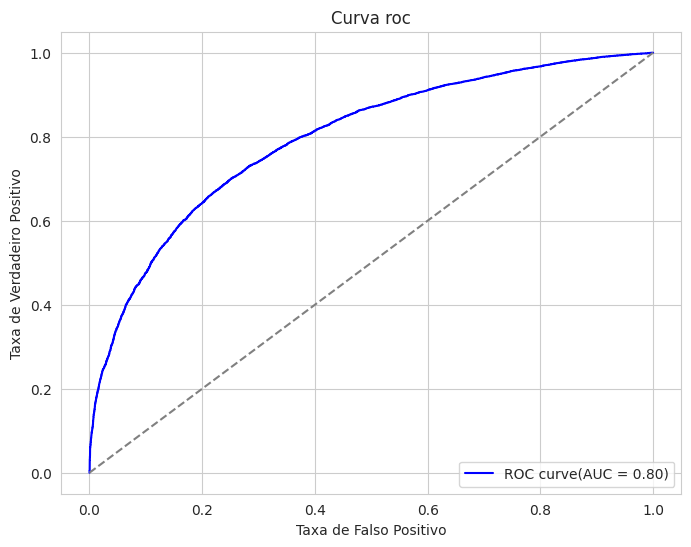

In [19]:
modelo_logistico = LogisticRegression()
roda_modelo(modelo_logistico)

##KNN (K-Nearest Neighbors)

O algoritmo KNN classifica novos dados com base na proximidade deles em relação aos dados de treinamento.  
Ele funciona assim:
- Para um novo ponto, identifica os **K vizinhos mais próximos**;
- A classe mais comum entre esses vizinhos é atribuída ao novo ponto.

É um método simples e eficaz, mas pode ser sensível à escolha do valor de K e ao balanceamento dos dados.


AUC: 0.8117874424738845

 Classification Report
              precision    recall  f1-score   support

           0       0.74      0.72      0.73     10403
           1       0.77      0.78      0.78     12397

    accuracy                           0.75     22800
   macro avg       0.75      0.75      0.75     22800
weighted avg       0.75      0.75      0.75     22800


 Roc Curve 



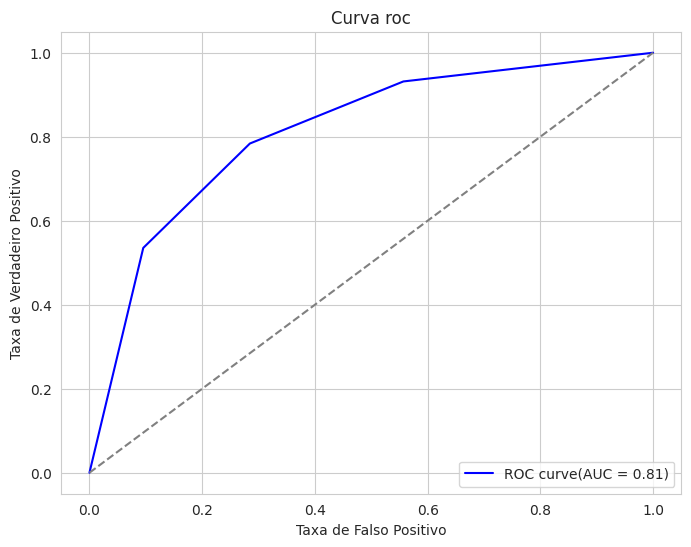

In [20]:
modelo_knn = KNeighborsClassifier(n_neighbors=3)
roda_modelo(modelo_knn)

## Random Forest

O **Random Forest** é um algoritmo de aprendizado por conjunto (ensemble learning) que constrói várias árvores de decisão e combina os resultados para melhorar a precisão e reduzir overfitting.

Como funciona:
- Cada árvore é treinada com uma amostra aleatória do conjunto de dados (bootstrap);
- A predição final é feita com base na **maioria dos votos** entre as árvores da floresta.

É um modelo robusto, versátil e com bom desempenho em várias tarefas de classificação.


AUC: 0.8307571916382204

 Classification Report
              precision    recall  f1-score   support

           0       0.73      0.71      0.72     10403
           1       0.76      0.78      0.77     12397

    accuracy                           0.75     22800
   macro avg       0.74      0.74      0.74     22800
weighted avg       0.75      0.75      0.75     22800


 Roc Curve 



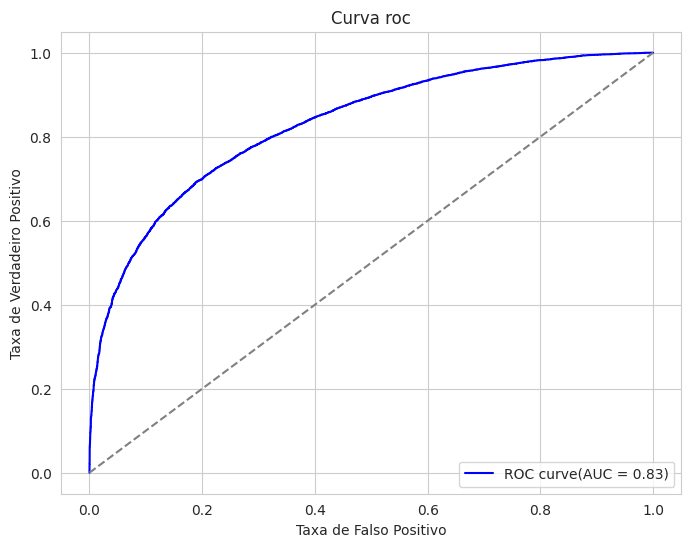

In [21]:
modelo_random_forest = RandomForestClassifier(max_depth=7, n_estimators= 100)
roda_modelo(modelo_random_forest)

## Otimizando Hiperparâmetros com Grid Search

Agora vamos utilizar o **GridSearchCV** para testar combinações de hiperparâmetros e encontrar aquela que oferece o melhor desempenho ao modelo.

⏳ *Atenção:* Esse processo pode ser demorado, já que testa várias combinações diferentes de forma exaustiva.


In [22]:


param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15]
}

GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='f1', n_jobs=1)

grid_search.fit(X_train_escalonado, y_train)

rf_params = grid_search.best_params_
print("Melhores hiperparâmetros:", rf_params)

Melhores hiperparâmetros: {'max_depth': 15, 'n_estimators': 300}


### Hiperparâmetros Otimizados

Os melhores hiperparâmetros encontrados foram:
```python
{'max_depth': 15, 'n_estimators': 300}


AUC: 0.9059350848550453

 Classification Report
              precision    recall  f1-score   support

           0       0.81      0.80      0.80     10403
           1       0.83      0.84      0.84     12397

    accuracy                           0.82     22800
   macro avg       0.82      0.82      0.82     22800
weighted avg       0.82      0.82      0.82     22800


 Roc Curve 



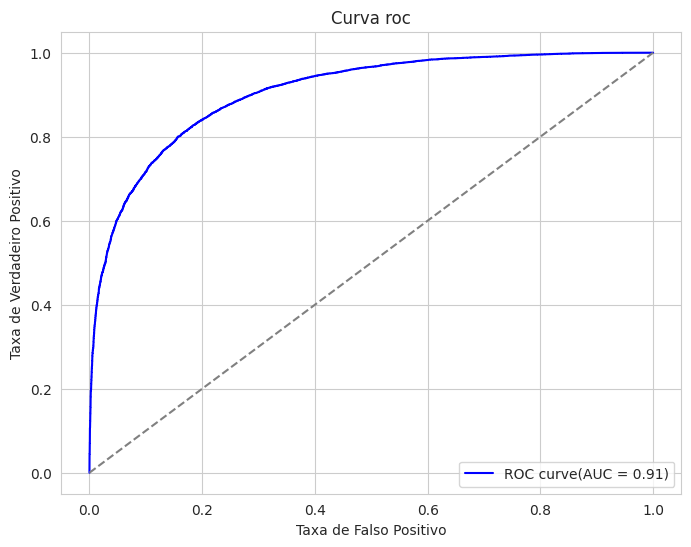

In [23]:
modelo_random_forest_gs = RandomForestClassifier(max_depth=15, n_estimators= 300)
roda_modelo(modelo_random_forest_gs)

## Avaliando o Modelo Otimizado

Com os hiperparâmetros ajustados, vamos reavaliar o modelo para verificar se houve melhora no desempenho.


In [24]:
novos_dados = pd.read_excel("novos_dados.xlsx")
base_original = pd.read_excel("novos_dados.xlsx")

#Criando a pipeline
coluna = ['track_genre']
label_encoder_dataframe(novos_dados, coluna)
novos_dados = scaler.transform(novos_dados)

# Realize a previsão usando o modelo Random Forest treinado
previsoes = modelo_random_forest_gs.predict(novos_dados)

# Obtendo o predict
def mapear_valor(valores):
    resultados = []
    for valor in valores:
        if valor == 0:
            resultados.append('Música agitada')
        elif valor == 1:
            resultados.append('Música lenta')
        else:
            resultados.append('Desconhecido')
    return np.array(resultados)

base_original['target'] = mapear_valor(previsoes)
base_original.head()

,popularity,duration_ms,danceability,energy,loudness,acousticness,instrumentalness,liveness,track_genre,target
0,80,200000,0.89,0.8,-19333,0.0555,0.976,0.45,rock,Música agitada
1,30,205000,0.20,0.5,-11773,0.0100,0.452,0.20,folk,Música lenta


## Previsão de Popularidade
Vamos treinar um modelo de regressão para prever o valor de popularidade das músicas com base em suas características.

In [25]:
!pip install -U scikit-learn

df = df.dropna()
df = df.select_dtypes(include=['number'])

X = df.drop(columns=['popularity'])
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 9.65
RMSE: 14.42
R²: 0.58


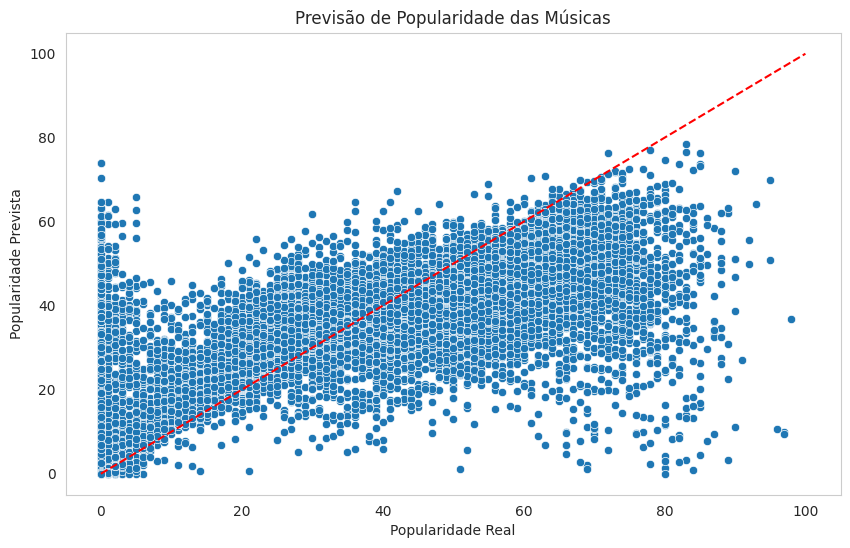

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Popularidade Real")
plt.ylabel("Popularidade Prevista")
plt.title("Previsão de Popularidade das Músicas")
plt.plot([0, 100], [0, 100], '--', color='red')
plt.grid()
plt.show()

## Conclusão

Neste projeto, utilizamos dados do Spotify para construir um modelo de classificação capaz de identificar se uma música é **agitada** ou **lenta**, com base em atributos de áudio como *valence*, *energy*, *danceability*, entre outros. A criação da variável alvo foi feita a partir do valor de `valence`, que indica a positividade emocional da faixa.

Exploramos diferentes algoritmos de Machine Learning, incluindo Regressão Logística, KNN e Random Forest. Após ajustes de hiperparâmetros com o GridSearchCV, o modelo de **Random Forest** obteve os melhores resultados, destacando-se pela robustez e capacidade de generalização. A análise da curva ROC e da métrica AUC confirmou seu bom desempenho.

Além da classificação, também desenvolvemos um modelo de **regressão** para prever a **popularidade** das músicas, alcançando métricas satisfatórias como RMSE e R², o que demonstra o potencial de modelos preditivos em aplicações relacionadas à indústria musical.

Este estudo mostra como é possível aplicar técnicas de Ciência de Dados para compreender e classificar conteúdos musicais de forma automatizada. Como próximos passos, podemos explorar novos algoritmos (como XGBoost), realizar ajustes mais finos de engenharia de atributos e até criar um sistema de recomendação musical baseado em preferências individuais.

